###

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rebound as rb
import reboundx as rx

ImportError: cannot import name 'MutableMapping' from 'collections' (/cita/modules/python/3.10.2/lib/python3.10/collections/__init__.py)

In [16]:
tup_num = 7 #change back to 7
e_b = np.linspace(0, 0.7, tup_num)
a_p = np.linspace(1, 5, tup_num)

Np = 4

Qex = []
for x in range(4,7):
    Q = 10**x
    Qex.append(Q)

tup_list = []

for Q in Qex:
    for e in e_b:
        for a in a_p:
            tup_list.append((Q,e,a,Np))

Ne = len(e_b)
Na = len(a_p)
Nq = len(Qex)

In [17]:
def survival(initial):    
    (Q, eb, ap, Np) = initial

    sim = rb.Simulation()
    sim.integrator = "whfast"
    
    mu = 0.5
    m1 = 1
    m2 = abs((m1*mu)/(1-mu))

    sim.add(m=m1, hash="Binary 1")
    sim.add(m=m2, a=1, e= eb, hash="Binary 2")
    
    R_star = 0.1*(1-0.5)**(1/3)
    sim.particles[0].r = R_star
    sim.particles[1].r = R_star
    
    #initializing Np massless planets
    
    for p in range(Np):
        f_plan = np.random.rand()*2*np.pi
        sim.add(m=0, a= ap, e=0, f= f_plan)
    
    #array to keep track of survival time
    sim.move_to_com()
    
    # Adding Tidal Elements
    rebx = rx.Extras(sim)
    tides = rebx.load_force("tides_constant_time_lag")
    rebx.add_force(tides)
    
    ps = sim.particles
    
    k2 = ps[0].params["tctl_k1"] = 0.035
    nb = ps[1].n
    tau = ps[0].params["tctl_tau"] = 3/(2*Q*k2*nb)
     
    directory = '/mnt/raid-cita/ksmith/jyp_notebook_tests/'
    rebx.save(directory+'rebxarchive.bin')
    sim.automateSimulationArchive(directory+r"jpy_eb{:.3f}_ap{:.3f}_Np{:.1f}_tup{:.1f}_Q{:.1f}_tau{:.4f}.bin"
                                  .format(eb,ap,Np,tup_num,Q,tau), interval=1e3, deletefile=True)
    
    #integrate
    N_times = int(100) #10,000
    N_orbit = (1e4)*2*np.pi
    times = np.linspace(0,N_orbit,N_times)
    surv = np.zeros(Np)
    
    for i, time in enumerate(times):
        
        nb = ps[1].n
        r_eb = ps[1].e
        
        N_re = (1+(15./2.)*r_eb**2+(45./8.)*r_eb**4+(5./16.)*r_eb**6)/(1-r_eb**2)**6
        Omega_re = (1+3*r_eb**2+(3./8.)*r_eb**4)/(1-r_eb**2)**(9./2.)
        ps[0].params["Omega"] = N_re/Omega_re*nb
        
        sim.integrate(time, exact_finish_time=0)
            
        for num in reversed(range(2, sim.N)):
            p = sim.particles[num]

            if (p.x**2 + p.y**2) > (100.)**2 or p.e > 1:
                surv[num-2] = time
                #print(f'removing planet {num}')
                sim.remove(num)
            
            if sim.N==2:
                break
                        
    surv[(surv==0)] = time
    #np.savetxt('/mnt/raid-cita/ksmith/CSTE_SUNNY/'+'raw_survival_time.bin', surv) 
    # saving raw survival time data w/out doing the mean
    
    print(f'simulation finished, {len(sim.particles)-2} planets remaining')
    return np.mean(surv) 

In [18]:
%%time
pool = rb.InterruptiblePool(processes=16)
mapping = pool.map(func= survival, iterable= tup_list)

simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 2 planets remaining
simulation finished, 4 planets remaining
simulation finished, 0 planets remaining
simulation finished, 0 planets remaining
simulation finished, 4 planets remaining
simulation finished, 4 planets remaining
simulation finished, 4 planets remaining
simulation finished, 4 planets remaining
simulation finished, 4 planets remaining
simulation finished, 4 planets remaining
simulation finis

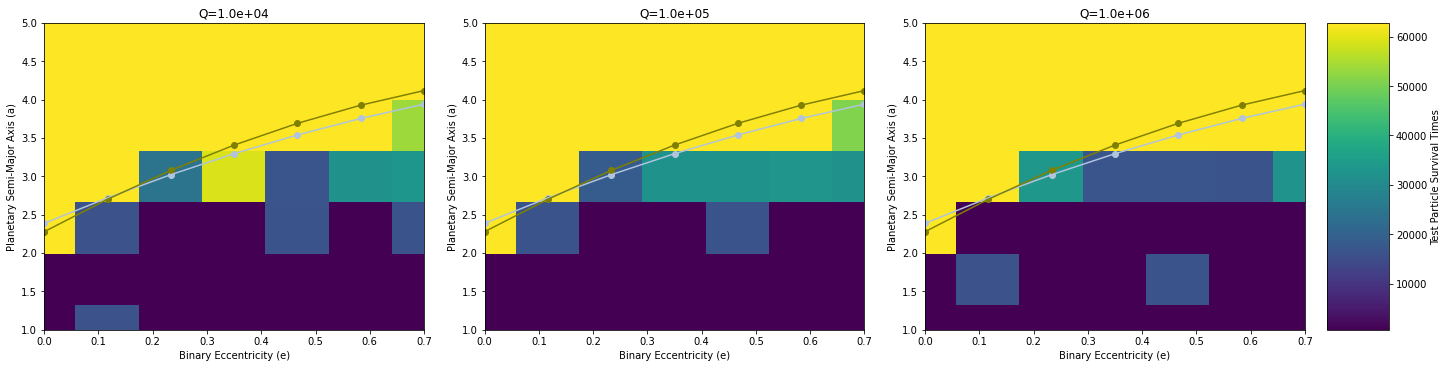

In [12]:
fig, ax = plt.subplots(1, Nq, figsize=(20,5), constrained_layout=True)
ax = ax.ravel()

SurvTimeAll = np.reshape(mapping, [Nq,Ne,Na])
       
SurvTimeArr = [SurvTimeAll[i,:,:] for i in range(Nq)]

for i in range(Nq):
    pcm = ax[i].pcolormesh(e_b, a_p, SurvTimeArr[i].T, shading='auto')
    
    a_b = 2.278 + 3.824*e_b - 1.71*(e_b**2)
    a_c = 1.6 + 5.1*e_b + (- 2.22*(e_b**2)) + 4.12*0.5 + (- 4.27*e_b*0.5) + (- 5.09*(0.5**2)) + 4.61*(e_b**2)*(0.5**2)
    
    ax[i].plot(e_b, a_c, color='lightsteelblue')
    ax[i].scatter(e_b, a_c, color='lightsteelblue')

    ax[i].plot(e_b, a_b, color='olive')
    ax[i].scatter(e_b, a_b, color='olive')
    
    ax[i].set_title('Q={:.1e}'.format(Qex[i]))
    ax[i].set_xlabel('Binary Eccentricity (e)')
    ax[i].set_ylabel('Planetary Semi-Major Axis (a)')
    ax[i].set_xlim(0.0,0.7)
    ax[i].set_ylim(1,5)

plt.colorbar(pcm, location='right',label='Test Particle Survival Times') 

In [ ]:
# 1D Slicing
plt.figure()
for i in range(Nq):
    plt.plot(a_p,SurvTimeArr[i][-1,:])

In [ ]:
""" Name of test sim archive with saved REBOUNDx archive"""
# test_eb0.583_ap5.000_Np4.0_tup7.0_Q1000000.0_tau0.0000.bin
sa2 = None

In [ ]:
sa2 = rx.SimulationArchive('test_eb0.583_ap5.000_Np4.0_tup7.0_Q1000000.0_tau0.0000.bin', rebxfilename='rebxarchive.bin')

print("Number of snapshots: %d" % len(sa2))

print(sa2[5][0].particles[0].params) 

# figure out how to access the Hash names, may be useful 

In [ ]:
sa1 = None

In [ ]:
sa1 = rb.SimulationArchive('eb0.437_ap2.000_Np15.0_tup25.0_Q10000.0_tau0.0030.bin')
print("Number of snapshots: %d" % len(sa1))
print(sa1[5].particles[2].omega)

# figure out how to access the Hash names, may be useful 